# Chatbot

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 08 - Sequence Modeling Applications/2- Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->


A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent.​

In [1]:
# download the required dataset from kaggle


! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d hijest/cleaned-data-for-the-chatbot-collected-from-movies

100% 305M/305M [00:11<00:00, 40.6MB/s]



In [2]:
!unzip /content/cleaned-data-for-the-chatbot-collected-from-movies.zip

Archive:  /content/cleaned-data-for-the-chatbot-collected-from-movies.zip
  inflating: dialogs_expanded.csv    
  inflating: input3.csv              
  inflating: model_att29iter_expanded.data-00000-of-00001  
  inflating: model_att29iter_expanded.index  
  inflating: target3.csv             


In [4]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection

# Read & Prepare the Data



## Read the CSV File


In [6]:
data_df = pd.read_csv("/content/dialogs_expanded.csv", index_col=False)

The csv file contains the following columns: Unnamed: 0,	question,	answer,	question_as_int,	answer_as_int,	question_len and 	answer_len.

We are interset in the question and	answer columns:
* The question column contains the questions sentences. 

* The answer column contains the answers sentences.

In [8]:
data_df

,Unnamed: 0,question,answer,question_as_int,answer_as_int,question_len,answer_len
0,1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,"[54, 67, 74, 74, 12, 1, 40, 1, 82, 70, 77, 83,...","[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...",71,55
1,2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,"[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...","[46, 73, 63, 87, 14, 14, 14, 1, 82, 70, 67, 76...",55,73
2,3,You're asking me out. That's so cute. What's ...,Forget it.,"[56, 77, 83, 8, 80, 67, 1, 63, 81, 73, 71, 76,...","[37, 77, 80, 69, 67, 82, 1, 71, 82, 14]",62,10
3,4,"No, no, it's my fault -- we didn't have a prop...",Cameron.,"[45, 77, 12, 1, 76, 77, 12, 1, 71, 82, 8, 81, ...","[34, 63, 75, 67, 80, 77, 76, 14]",65,8
4,9,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.,"[38, 77, 81, 70, 12, 1, 71, 68, 1, 77, 76, 74,...","[43, 67, 82, 1, 75, 67, 1, 81, 67, 67, 1, 85, ...",46,25
...,...,...,...,...,...,...,...
139404,221608,Well that one. The one who keeps looking at me.,ft could be you flatter yourself CoghilL It's ...,"[54, 67, 74, 74, 1, 82, 70, 63, 82, 1, 77, 76,...","[68, 82, 1, 65, 77, 83, 74, 66, 1, 64, 67, 1, ...",47,59
139405,221609,Choose your targets men. That's right Watch th...,Keep steady. You're the best shots of the Twen...,"[34, 70, 77, 77, 81, 67, 1, 87, 77, 83, 80, 1,...","[42, 67, 67, 78, 1, 81, 82, 67, 63, 66, 87, 14...",61,85
139406,221610,Colonel Durnford... William Vereker. I hear yo...,"Good ones, yes, Mr Vereker. Gentlemen who can ...","[34, 77, 74, 77, 76, 67, 74, 1, 35, 83, 80, 76...","[38, 77, 77, 66, 1, 77, 76, 67, 81, 12, 1, 87,...",74,60
139407,221611,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...,"[56, 77, 83, 80, 1, 77, 80, 66, 67, 80, 81, 12...","[40, 8, 75, 1, 82, 77, 1, 82, 63, 73, 67, 1, 8...",24,56


## Prepare the Data
Prepare the data by :
* Drop the Unnamed: 0, question_as_int, answer_as_int, question_len and answer_len columns.
* Clean the sentences by removing special characters.
* Add a start and end token to each sentence.
* Tokenize the sentences.
* Pad each sentence to a maximum length.
* Split the data into training and testing sets.

In [9]:
data_df.drop(
    ["Unnamed: 0", "question_as_int", "answer_as_int", "question_len", "answer_len"],
    axis=1,
    inplace=True,
)

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139409 entries, 0 to 139408
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  139409 non-null  object
 1   answer    139409 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [11]:
data_df

,question,answer
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.
...,...,...
139404,Well that one. The one who keeps looking at me.,ft could be you flatter yourself CoghilL It's ...
139405,Choose your targets men. That's right Watch th...,Keep steady. You're the best shots of the Twen...
139406,Colonel Durnford... William Vereker. I hear yo...,"Good ones, yes, Mr Vereker. Gentlemen who can ..."
139407,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...


In [14]:
def clean_text(text):
    """Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers."""
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\n", "", text)
    text = re.sub(r"[^\w]", " ", text)
    text = re.sub("\w*\d\w*", "", text)
    text = " ".join(filter(lambda x: x[0] != "@", text.split()))
    return text


data_df.question = data_df.question.map(clean_text)
data_df.answer = data_df.answer.map(clean_text)

In [15]:
data_df

,question,answer
0,well i thought we d start with pronunciation i...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...
2,you re asking me out that s so cute what s you...,forget it
3,no no it s my fault we didn t have a proper in...,cameron
4,gosh if only we could find kat a boyfriend,let me see what i can do
...,...,...
139404,well that one the one who keeps looking at me,ft could be you flatter yourself coghill it s ...
139405,choose your targets men that s right watch tho...,keep steady you re the best shots of the twent...
139406,colonel durnford william vereker i hear you ve...,good ones yes mr vereker gentlemen who can rid...
139407,your orders mr vereker,i m to take the sikali with the main column to...


In [16]:
# add <start> and <end> tokens to the start and end of each sentence
def add_start_end(text):
    text = f"<start> {text} <end>"
    return text


data_df.question = data_df.question.map(add_start_end)
data_df.answer = data_df.answer.map(add_start_end)

In [17]:
data_df

,question,answer
0,<start> well i thought we d start with pronunc...,<start> not the hacking and gagging and spitti...
1,<start> not the hacking and gagging and spitti...,<start> okay then how bout we try out some fre...
2,<start> you re asking me out that s so cute wh...,<start> forget it <end>
3,<start> no no it s my fault we didn t have a p...,<start> cameron <end>
4,<start> gosh if only we could find kat a boyfr...,<start> let me see what i can do <end>
...,...,...
139404,<start> well that one the one who keeps lookin...,<start> ft could be you flatter yourself coghi...
139405,<start> choose your targets men that s right w...,<start> keep steady you re the best shots of t...
139406,<start> colonel durnford william vereker i hea...,<start> good ones yes mr vereker gentlemen who...
139407,<start> your orders mr vereker <end>,<start> i m to take the sikali with the main c...


## Tokenize the Sentences

In [18]:
# Create the sequence & tokenizer for the data
def tokenize(lang):
    # create a tokenizer object
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        oov_token="<OOV>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
    )  # remove  < and >  from the filter list
    # fit the tokenizer on the texts
    lang_tokenizer.fit_on_texts(lang)
    # tokenize the texts and create a seqence
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # pad the sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post")
    # return the tokenizer and the sequence

    return tensor, lang_tokenizer

In [19]:
# create the tokenizer and the sequence for the questions
question_sequence, question_tokenizer = tokenize(data_df.question)
# create the tokenizer and the sequence for the answers
answer_sequence, answer_tokenizer = tokenize(data_df.answer)

In [20]:
# create nesseary variables
# the size of the vocabulary for the question and the answer
vocab_inp_size = len(question_tokenizer.word_index) + 1
vocab_tar_size = len(answer_tokenizer.word_index) + 1
# set the embedding dimension for the question and answer
embedding_dim = 256
# set the hidden units for the encoder and the decoder
units = 1024
# set the batch size
batch_size = 32

## split the data into train and test

In [21]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    question_sequence, answer_sequence, test_size=0.1
)

In [22]:
x_train.shape  # get the shape of the training data

(125468, 29)

In [23]:
# create converters for the question and answer
# the converters are used to convert the index to the word
def convert(token, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, token.index_word[t]))

In [24]:
# convert simple question sentence to word
print("question ; index to word mapping")
convert(question_tokenizer, x_train[0])
print()
print("answar; index to word mapping")
convert(answer_tokenizer, y_train[0])

question ; index to word mapping
2 ----> <start>
32 ----> my
1331 ----> gift
7 ----> to
4 ----> you
3 ----> <end>

answar; index to word mapping
2 ----> <start>
452 ----> under
6 ----> the
891 ----> table
3 ----> <end>


# Create the Data Pipeline for the Model

In [26]:
# create the data pipeline for the training data
def create_data_pipline(x, y, batch_size=32):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    # shuffle the data
    data = data.shuffle(1028)
    # batch the data
    # set the drop_remainder to true to drop the last batch if the size of it not equal to 32
    data = data.batch(batch_size, drop_remainder=True)
    # prefetch the data
    data = data.prefetch(tf.data.AUTOTUNE)
    # return the data
    return data


# create the data pipeline for the training data
train_dataset = create_data_pipline(x_train, y_train)
# create the data pipeline for the testing data
test_dataset = create_data_pipline(x_test, y_test)

In [27]:
# get the first batch of the training data
for question, answer in train_dataset.take(1):
    print(f"question:{question.shape}\n{question}")

    print(f"answer:{answer.shape}\n{answer}")
    question_sample = question
    answer_sample = answer

question:(32, 29)
[[    2  9480  7877 26838  1324  2148   376    12  6658    54     4   290
      3     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2   125    49    47     8    86  3209  1271    10  7572    13   755
   1280   190  3430     3     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2   681     4    21    11    28     7    59   118    47     3     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2  1281    24     3     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2   179   215    61     3     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2    51     8  1244    10   203  5049     3     0     0     0     0
   

# Create the Seq2Seq Model Architecture

Let’s take a look at a simple neural machine translation model that will translate
English sentences to Spanish.
In short, the English sentences are fed to the encoder, and the decoder outputs the
Spanish translations. Note that the Spanish translations are also used as inputs to the
decoder, but shifted back by one step. In other words, the decoder is given as input
the word that it should have output at the previous step (regardless of what it actually
output). For the very first word, it is given the start-of-sequence (`<START>`) token. The
decoder is expected to end the sentence with an end-of-sequence (`<END>`) token.

Each word is initially represented by its ID (e.g., 288 for the word “milk”). Next, an
embedding layer returns the word embedding. These word embeddings are what is
actually fed to the encoder and the decoder.

## Encoder Model

The encoder is at the feeding end; it understands the sequence and reduces the dimension of the input sequence. The sequence has a fixed size known as the context vector. This context vector acts like input to the decoder, which generates an output sequence when reaching the end token. Hence, you can call these seq2seq models encoder-decoder models.

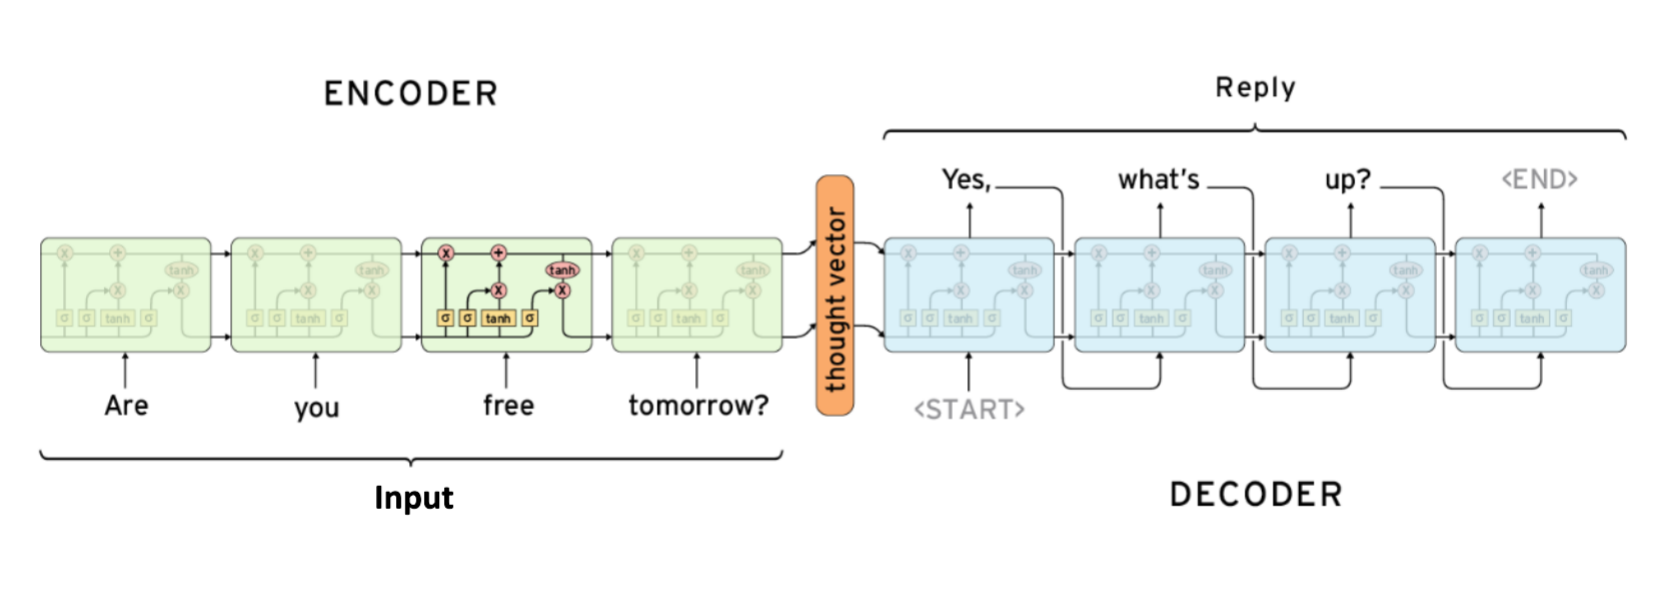

In [49]:
# Create the encoder model
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        #
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        # create the embedding layer
        # mask_zero is set to True to ignore the zero padding
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, mask_zero=True
        )
        # create the GRU layer and return the sequences and the state
        self.gru = tf.keras.layers.GRU(
            self.encoder_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x, hidden):
        # pass the input through the embedding layer
        x = self.embedding(x)
        # pass the input through the GRU layer and return the sequences and the state
        # for this application there is no need to the ouptut of the GRU layer
        # the state shape of the GRU layer is (batch_size, encoder_units)
        # the sequences shape of the GRU layer is (batch_size, max_length, encoder_units)
        output, state = self.gru(x, initial_state=hidden)

        # return the output and the state
        return output, state

    # initialize the hidden state
    def initialize_hidden_state(self):
        # create a tensor of zeros of shape [batch_size, encoder_units]
        return tf.zeros((self.batch_size, self.encoder_units))

## Decoder Model

If you use GRU for the encoder, use the same for the decoder. But it's slightly more complex than the encoder network. You can say the decoder is in an "aware state." It knows what words you have generated so far and what the previous hidden state was. 

The first layer of the decoder is initialized by using the context vector 'C' from the encoder network to generate the output. 

Then a special token is applied at the start to indicate the output generation. It applies a similar token at the end. The first output word is generated by running the stacked GRU layers. A SoftMax activation function applies to the last layer. 

Its job is to introduce non-linearity in the network. 

Now this word is passed through the remaining layers and the generation sequence is repeated.



In [50]:
# Create the decoder model
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoder_units = decoder_units
        # create the embedding layer
        # mask_zero is set to True to ignore the zero padding
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, mask_zero=True
        )
        # create the GRU layer and return the sequences and the state
        self.gru = tf.keras.layers.GRU(
            self.decoder_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        # create the dense layer to map the output of the GRU layer to the vocabulary size
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):

        # pass the input through the embedding layer
        x = self.embedding(x)

        # passing the input to the GRU with the previous hidden state as the initial state.
        # the shape of the output of the GRU layer is (batch_size, max_length, decoder_units)
        # the shape of the state is (batch_size, decoder_units)
        # the shape of hidden is (batch_size, decoder_units)
        output, hidden = self.gru(x, hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = tf.nn.softmax(self.fc(output))

        return x, hidden

## Test the Encoder and Decoder Models

In [51]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)

# sample input
# inilize the hidden state with zeros
# the shape of hidden is (batch_size, units)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(question, sample_hidden)
print(
    "Encoder output shape: (batch size, sequence length, units) {}".format(
        sample_output.shape
    )
)
print("Encoder Hidden state shape: (batch size, units) {}".format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (32, 29, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [52]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, batch_size)
# the shape of sample hidden is (batch_size, units)
sample_decoder_output, _ = decoder(tf.random.uniform((batch_size, 1)), sample_hidden)

print(
    "Decoder output shape: (batch_size, vocab size) {}".format(
        sample_decoder_output.shape
    )
)

Decoder output shape: (batch_size, vocab size) (32, 27849)


# Create the Optimizer and the Loss Function

In [53]:
# create the optimizer using the Adam optimizer
optimizer = tf.keras.optimizers.Adam()
# create the loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# define the loss function for the training
def loss_function(real, pred):
    # create the mask to ignore the padding tokens
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # mask shape == (batch_size, sequence_length)
    # calculate the loss
    loss_ = loss_object(real, pred)
    # mask the loss
    # how the mask works:
    # if the value is 1, the loss is calculated
    # if the value is 0, the loss is ignored
    # [1,1,1,1,1,1,0,0,0,0,0] mask
    # *
    # [2,6,2,1,6,3,2,1,5,7,9] input
    # =
    # [2,6,2,1,6,3,0,0,0,0,0] output
    mask = tf.cast(mask, dtype=loss_.dtype)
    # mask shape == (batch_size, sequence_length)

    loss_ *= mask
    # calculate the average loss per batch
    return tf.reduce_mean(loss_)

In [54]:
# create the training metric
train_loss = tf.metrics.Mean(name="train loss")
# create the testing metric
test_loss = tf.metrics.Mean(name="test loss")

# Create the Training Step 

## Computing Gradients Using Autodiff



[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) is useful for implementing machine learning algorithms such as backpropagation for training neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.


To in inderstand how to compute gradients with TensorFlow, you need to understand the automatic differentiation process.
for example, if you have a function f(x) and you want to compute the gradient of f(x), you can use the following code:



In [55]:
def f(w1, w2):

    return 3.0 * w1**2.0 + 2.0 * w1 * w2


z = f(5, 3)
print(z)

105.0



If you know calculus, you can analytically find that the partial derivative of this function with regard to `w1` is` 6 * w1 + 2 * w2`. 
You can also find that its partial derivative with regard to `w2` is `2 * w1`.

For example, at the point `(w1, w2) = (5, 3)`, these partial derivatives are equal to `36` and `10`, respectively, so the gradient vector at this point is `(36, 10)`. 
But if this were a neural network, the function would be much more complex, typically with tens of thousands of parameters, and finding the partial derivatives analytically by hand would be an almost impossible task. 

TensorFlow provides a way to compute the partial derivatives of a function with regard to its parameters automatically.
TensorFlow makes this pretty simple by using the [GradientTape](https://www.tensorflow.org/guide/autodiff) class.

Fro example, if you have a function `f(x)` and you want to compute the gradient of `f(x)`, you can use the following code:



In [56]:
# create two trainble variables using tf.Variable
w1, w2 = tf.Variable(5.0), tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

We first define two variables `w1` and `w2`, then we create a `tf.GradientTape` context
that will automatically record every operation that involves a variable, and finally we
ask this tape to compute the gradients of the result `z` with regard to both variables
`[w1, w2]`. Let’s take a look at the gradients that TensorFlow computed:

In [57]:
print(gradients)

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]


Perfect! Not only is the result accurate (the precision is only limited by the floating point errors), but the `gradient()` method only goes through the recorded computations once (in reverse order), no matter how many variables there are, so it is
incredibly efficient. It’s like magic!

The tape is automatically erased immediately after you call its `gradient()` method, so
you will get an exception if you try to call `gradient()` twice:

In [58]:
with tf.GradientTape() as tape:
    z = f(w1, w2)
dz_dw1 = tape.gradient(z, w1)  # => tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # RuntimeError!

RuntimeError: ignored

If you need to call `gradient()` more than once, you must make the tape `persistent`
and delete it each time you are done with it to free resources:

In [59]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)
dz_dw1 = tape.gradient(z, w1)  # => tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # => tensor 10.0
print(dz_dw1)
print(dz_dw2)

tf.Tensor(36.0, shape=(), dtype=float32)
tf.Tensor(10.0, shape=(), dtype=float32)


Most of the time a gradient tape is used to compute the gradients of a single value
(usually the loss) with regard to a set of values (usually the model parameters). This is
where reverse-mode autodiff shines, as it just needs to do one forward pass and one
reverse pass to get all the gradients at once. If you try to compute the gradients of a
vector, for example a vector containing multiple losses, then TensorFlow will compute the gradients of the vector’s sum. 

In [60]:
# create the training step
# using the tf.function decorator to speed up the training process by converting the training function to a TensorFlow graph
@tf.function
# define the training step
def train_step(inputs, target, enc_hidden):
    # the encoder_hidden is the initial hidden state of the encoder
    # enc_hidden shape == (batch_size, hidden_size)

    # inilaize the loss to zero
    loss = 0
    # create the gradient tape to record the gradient of the loss with respect to the weights

    with tf.GradientTape() as tape:
        # pass the input to the encoder
        # enc_output shape == (batch_size, 49, hidden_size)
        # enc_hidden shape == (batch_size, hidden_size)
        # using the encoder to get the encoder_output and the encoder_hidden
        # using the encoder_hidden as the initial hidden state of the decoder
        enc_output, enc_hidden = encoder(inputs, enc_hidden)
        # set the initial decoder hidden state to the encoder hidden state
        dec_hidden = enc_hidden

        # create the start token
        # start_token shape == (batch_size, 1)
        # repeat the start token for the batch size times
        dec_input = tf.expand_dims(
            [answer_tokenizer.word_index["<start>"]] * inputs.shape[0], 1
        )

        # Teacher forcing - feeding the target as the next input

        for t in range(1, target.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            # calculate the loss for the current time step using the loss function
            loss += loss_function(target[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)
    # calculate the loss for the current batch
    batch_loss = loss / int(target.shape[1])

    # get the trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables
    # calculate the gradients using the tape
    gradients = tape.gradient(loss, variables)
    # update the trainable variables
    optimizer.apply_gradients(zip(gradients, variables))
    # add the loss to the training loss metric
    train_loss(batch_loss)
    return batch_loss

## Create the Test Step Function

In [61]:
# create the training step
# using the tf.function decorator to speed up the training process by converting the training function to a TensorFlow graph
@tf.function
def test_step(inputs, target, enc_hidden):
    # the encoder_hidden is the initial hidden state of the encoder
    # enc_hidden shape == (batch_size, hidden_size)
    # inilaize the loss to zero
    loss = 0
    # pass the input to the encoder
    # enc_output shape == (batch_size, 49, hidden_size)
    # enc_hidden shape == (batch_size, hidden_size)
    # using the encoder to get the encoder_output and the encoder_hidden
    enc_output, enc_hidden = encoder(inputs, enc_hidden)
    # set the initial decoder hidden state to the encoder hidden state
    dec_hidden = enc_hidden
    # create the start token
    # start_token shape == (batch_size, 1)
    # repeat the start token for the batch size times
    dec_input = tf.expand_dims(
        [answer_tokenizer.word_index["<start>"]] * inputs.shape[0], 1
    )
    for t in range(1, target.shape[1]):
        # passing enc_output to the decoder with dec_hidden as the initial hidden state
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        # calculate the loss for the current time step using the loss function
        loss += loss_function(target[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, t], 1)
    # calculate the loss for the current batch
    batch_loss = loss / int(target.shape[1])
    # add the batch loss to the test loss metric
    test_loss(batch_loss)

# Create the Training Loop 

In [62]:
# set the epochs to 3
EPOCHS = 10
# set the old test loss to high number

old_test_loss = 1000000
# create the training loop
for epoch in range(EPOCHS):
    # reset the training loss metric
    train_loss.reset_states()
    # reset the testing loss metric
    test_loss.reset_states()

    # initalize the hidden state of the encoder to zeros
    enc_hidden = encoder.initialize_hidden_state()
    # create the training progress bar set the total number of batches to the length of the training dataset and the batch size to the test size
    steps_per_epoch = (
        answer_sequence.shape[0] // batch_size
    )  # => 4356 batch in the dataset
    bar = tf.keras.utils.Progbar(target=steps_per_epoch)

    count = 0
    # iterate over the training dataset
    for (batch, (inputs, target)) in enumerate(train_dataset):
        # update the progress bar
        count += 1
        # run the training step
        batch_loss = train_step(inputs, target, enc_hidden)
        bar.update(count)  # manually update the progress bar

    # iterate over the testing dataset
    for (batch, (inputs, target)) in enumerate(test_dataset):
        count += 1
        # run the testing step
        batch_loss = test_step(inputs, target, enc_hidden)
        bar.update(count)
    # save the best performance model on the test dataset

    if old_test_loss > test_loss.result():
        # set the old test loss to the test loss
        old_test_loss = test_loss.result()
        encoder.save(filepath="/content/models/encoder")
        decoder.save(filepath="/content/models/decoder")
        print("Model is saved")
    # print the training and testing loss
    print("#" * 50)
    print(f"Epoch #{epoch + 1}")
    print(f"Training Loss {train_loss.result()}")
    print(f"Testing Loss {test_loss.result()}")
    print("#" * 50)

4355/4356 [============================>.] - ETA: 0s

INFO:tensorflow:Assets written to: /content/models/encoder/assets


INFO:tensorflow:Assets written to: /content/models/encoder/assets


INFO:tensorflow:Assets written to: /content/models/decoder/assets


INFO:tensorflow:Assets written to: /content/models/decoder/assets


Model is saved
##################################################
Epoch #1
Training Loss 1.3890328407287598
Testing Loss 1.2819832563400269
##################################################
4354/4356 [============================>.] - ETA: 0s##################################################
Epoch #2
Training Loss 1.1918753385543823
Testing Loss 1.2825216054916382
##################################################
4355/4356 [============================>.] - ETA: 0s##################################################
Epoch #3
Training Loss 1.0440216064453125
Testing Loss 1.3288350105285645
##################################################
4355/4356 [============================>.] - ETA: 0s##################################################
Epoch #4
Training Loss 0.9154393076896667
Testing Loss 1.378799557685852
##################################################
4355/4356 [============================>.] - ETA: 0s##################################################
Epoch #5
Training Loss 

# Let's Play with the ChatBot

In [70]:
# create the chatbot function
# the chatbot function takes in the question as input and answers the input sentence
def chatbot(sentence):

    # clean the input question sentence
    sentence = clean_text(sentence)
    # add the start token to the sentence
    sentence = add_start_end(sentence)
    # tokenize the sentence
    inputs = question_tokenizer.texts_to_sequences([sentence])
    # pad the sentence
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        inputs, maxlen=29, padding="post"
    )

    # initalize the hidden state of the encoder to zeros
    hidden = [tf.zeros((1, units))]
    # pass the sentence to the encoder with the hidden state as the initial hidden state
    enc_out, enc_hidden = encoder(inputs, hidden)
    # set the initial decoder hidden state to the encoder hidden state
    dec_hidden = enc_hidden
    # create the start token
    # start_token shape == (batch_size, 1)
    # repeat the start token for the batch size times
    dec_input = tf.expand_dims([answer_tokenizer.word_index["<start>"]], 0)
    # create the result string
    result = ""
    # loop over the length of the sentence (32)

    for t in range(32):
        # passing the encoder output and the decoder hidden state to the decoder make sure the decoder input is the previous predicted word
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        # getting the predicted word index
        predicted_id = tf.argmax(predictions[0]).numpy()
        # getting the predicted word using the predicted index
        # add the predicted word to the result string
        result += answer_tokenizer.index_word[predicted_id] + " "
        # if the predicted word is the <end> token then stop the loop
        if answer_tokenizer.index_word[predicted_id] == "<end>":
            # remove the <start> and <end> tokens from the result string
            result = result.replace("<start> ", "")
            result = result.replace(" <end> ", "")
            # remove the <start> and <end> tokens from the sentence string
            sentence = sentence.replace("<start> ", "")
            sentence = sentence.replace(" <end>", "")
            return sentence, result

        # using the predicted word as the next decoder input
        dec_input = tf.expand_dims([predicted_id], 0)
    # remove the <start> and <end> tokens from the result string
    result = result.replace("<start> ", "")
    result = result.replace("<end>", "")
    # remove the <start> and <end> tokens from the sentence string
    sentence = sentence.replace("<start> ", "")
    sentence = sentence.replace("<end>", "")

    # return the result string and the original sentence
    return sentence, result

In [89]:
chatbot("how are you today")

('how are you today', 'i m fine')

In [90]:
chatbot("what is the weather outside")

('what is the weather outside', 'i don t know')

In [103]:
chatbot("can you run")

('can you run', 'yeah sure')